In [1]:
import os

import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline

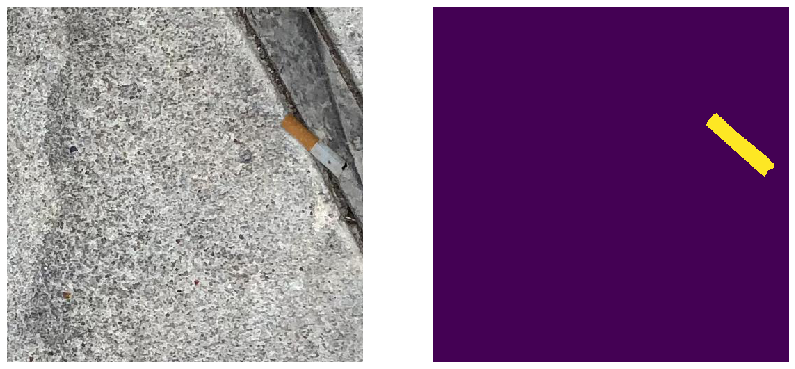

(512, 512, 3)

In [2]:
path = "data/train"
images = os.listdir(f"{path}/images")
annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
img_id = int(np.random.choice(images).split(".")[0])

img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
mask = get_mask(img_id, annotations)
show_img_with_mask(img, mask)
img.shape

In [33]:
def keras_generator(path, batch_size):

        
    while True:
        images = os.listdir(f"{path}/images")
        annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_id = int(np.random.choice(images).split(".")[0])
            img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
            mask = get_mask(img_id, annotations)
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) /255.

        yield x_batch, np.expand_dims(y_batch, -1)

In [73]:
def load_data(path, batch_size):

        
    while True:
        images = os.listdir(f"{path}/images")
        annotations = json.load(open(f"{path}/coco_annotations.json", "r"))
        x_batch = []
        y_batch = []
            
        for i in range(batch_size):
            img_id = i
            img = np.array(Image.open(f"{path}/images/{img_id:08}.jpg"))
            mask = get_mask(img_id, annotations)
            img = cv2.resize(img, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.


        return x_batch, y_batch

In [118]:
#функция для получения тестового датасета
def get_test( path,batch_size):

        
    while True:
        x_batch = []
        
        for i in range(batch_size):
            img_id = i
            img = np.array(Image.open(f"{path}/real_test/images/{img_id:04}.jpg"))
            img = cv2.resize(img, (256, 256))

            x_batch += [img]

        x_batch = np.array(x_batch) / 255.
        return x_batch

In [35]:
for x, y in keras_generator('data/val1',16):
    break

In [5]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

Using TensorFlow backend.
C:\Users\lasic\Anaconda3\envs\coursera_ds\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
base_out

<tf.Tensor 'activation_49/Relu:0' shape=(None, 8, 8, 2048) dtype=float32>

In [7]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [8]:
conv1 = base_model.get_layer('activation_1').output
conv2 = base_model.get_layer('activation_4').output
conv3 = base_model.get_layer('activation_15').output
conv4 = base_model.get_layer('activation_24').output
conv5 = base_model.get_layer('activation_44').output


inp = base_model.get_layer('input_1').output

In [9]:
conv1

<tf.Tensor 'activation_1/Relu:0' shape=(None, 128, 128, 64) dtype=float32>

In [10]:
conv2

<tf.Tensor 'activation_4/Relu:0' shape=(None, 64, 64, 256) dtype=float32>

In [11]:
conv3

<tf.Tensor 'activation_15/Relu:0' shape=(None, 32, 32, 128) dtype=float32>

In [12]:
conv4

<tf.Tensor 'activation_24/Relu:0' shape=(None, 16, 16, 256) dtype=float32>

In [13]:
conv5

<tf.Tensor 'activation_44/Relu:0' shape=(None, 8, 8, 512) dtype=float32>

In [14]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5)

In [15]:
conv_conc_5

<tf.Tensor 'activation_54/Sigmoid:0' shape=(None, 256, 256, 1) dtype=float32>

In [16]:
model = Model(input=base_model.input, output=conv_conc_5)

C:\Users\lasic\Anaconda3\envs\coursera_ds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  """Entry point for launching an IPython kernel.


In [17]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [18]:
batch_size = 16
model.fit_generator(keras_generator('data/train', batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator('data/val1', batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 1628s 16s/step - loss: 0.0729 - val_loss: 0.1493
Epoch 2/100
100/100 [==============================] - 1627s 16s/step - loss: 0.0087 - val_loss: 0.2396
Epoch 3/100
100/100 [==============================] - 1609s 16s/step - loss: 0.0056 - val_loss: 0.3873
Epoch 4/100
100/100 [==============================] - 1669s 17s/step - loss: 0.0045 - val_loss: 0.3161
Epoch 5/100
100/100 [==============================] - 1615s 16s/step - loss: 0.0039 - val_loss: 0.2489
Epoch 6/100
100/100 [==============================] - 1628s 16s/step - loss: 0.0034 - val_loss: 0.2534
Epoch 7/100
100/100 [==============================] - 1621s 16s/step - loss: 0.0028 - val_loss: 0.1297
Epoch 8/100
100/100 [==============================] - 1650s 16s/step - loss: 0.0027 - val_loss: 0.0754
Epoch 9/100
 60/100 [=================>............] - ETA: 9:37 - loss: 0.0027

KeyboardInterrupt: 

In [19]:
pred = model.predict(x)

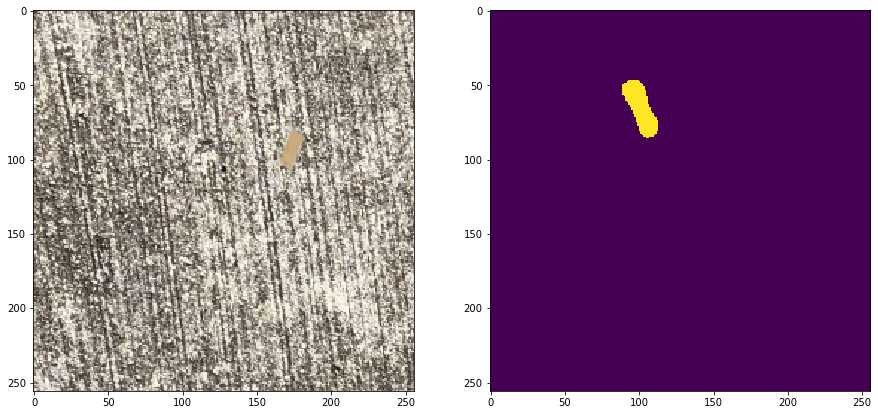

In [36]:
im_id = 10
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

In [74]:
train_data, val_mask =load_data('data/val1', 200)

In [38]:
pred = model.predict(train_data)

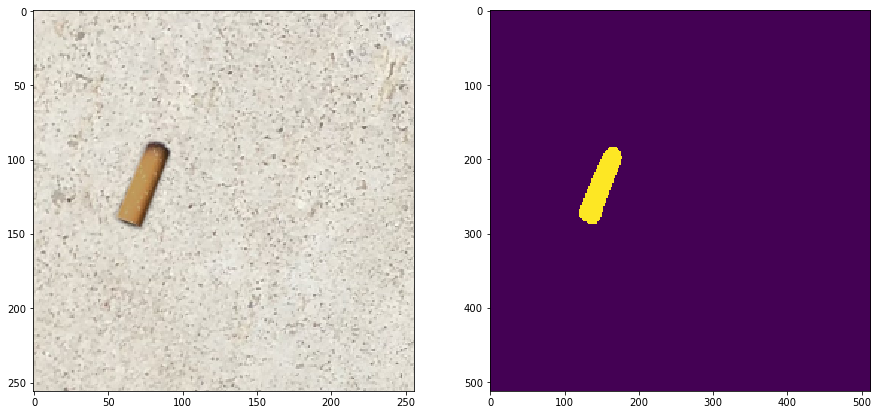

In [52]:
im_id = 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(train_data[im_id])
axes[1].imshow(A)

plt.show()

**Запишем маски**

In [202]:
def det_mask(pred, val):
    A= np.zeros((256, 256))
    for i in range(256):
        for j in range(256):
            if (pred[i,j,0] > val):
                A[i,j]=1
    A = cv2.resize(A, (512, 512))
    
    for i in range(512):
        for j in range(512):
            if (A[i,j] != 1):
                A[i,j]=0
    return A

In [51]:
A=det_mask(pred[1], 0.5)

In [205]:
ans=[]

In [206]:
for i in range(200):
    ans.append(encode_rle(det_mask(pred[i], 0.5)))

In [207]:
(type(ans[0]))

str

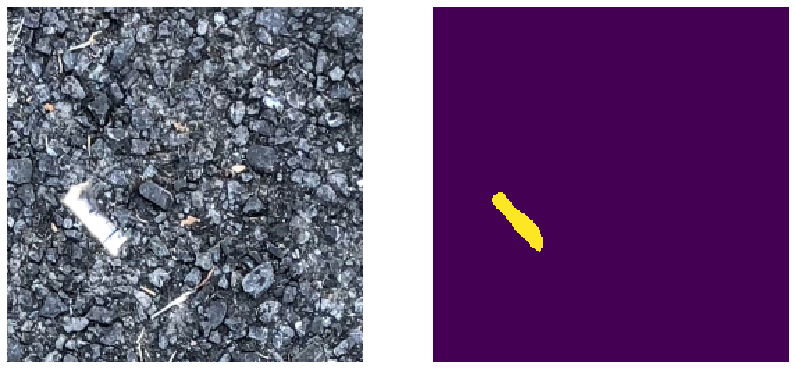

In [60]:
img = train_data[98]
show_img_with_mask(img, decode_rle(ans[98]))

In [208]:
index=[]
for i in range(200):
    index.append(i)

In [209]:
d = {"img_id": index,
    "rle_mask": ans}

df = pd.DataFrame(d, index)

In [210]:
df.head()

,img_id,rle_mask
0,0,75614 2 76126 2 76634 10 77146 10 77658 12 781...
1,1,93856 10 94368 10 94878 14 95390 14 95900 18 9...
2,2,52976 8 53488 8 53998 10 54510 10 55020 12 555...
3,3,24306 2 24818 2 25322 14 25834 14 26340 22 268...
4,4,159544 10 160056 10 160566 14 161078 14 161586...


In [211]:
filename = 'Unet_ResNet_Best.csv'
df.to_csv(filename, index=False, encoding='utf-8')

In [212]:
a2 = df.rle_mask

In [216]:
decode_rle(a2[4])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [85]:
val_mask[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [89]:
ans1=[]
for i in range(200):
    ans1.append((det_mask(pred[i], 0.5)))

# Анализ метрик:

In [99]:
get_dice(val_mask,ans1)

0.547057133170104

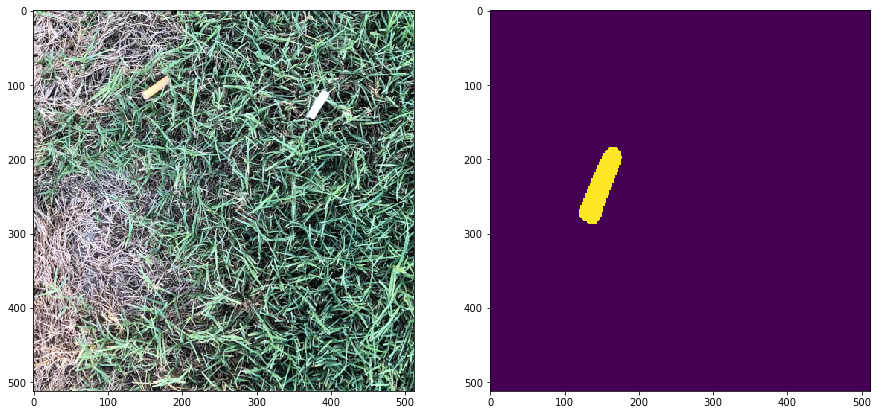

In [107]:
im_id = 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(val_mask[im_id])
axes[1].imshow(ans1[im_id])

plt.show()

# Данные из test:

In [139]:
def save_html_new(paths_to_imgs, pred_masks, path_to_save="results/test"):
    
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))[:, :, :3]
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        rle_mask = encode_rle(pred_mask)
        decoded_mask = decode_rle(rle_mask)
        Image.fromarray(decoded_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")


In [140]:
new_test = get_test('data',10)
new_test.shape

(10, 256, 256, 3)

In [144]:
answer_test=model.predict(new_test)

In [145]:
ans2=[]
for i in range(10):
    ans2.append((det_mask(answer_test[i], 0.5)))

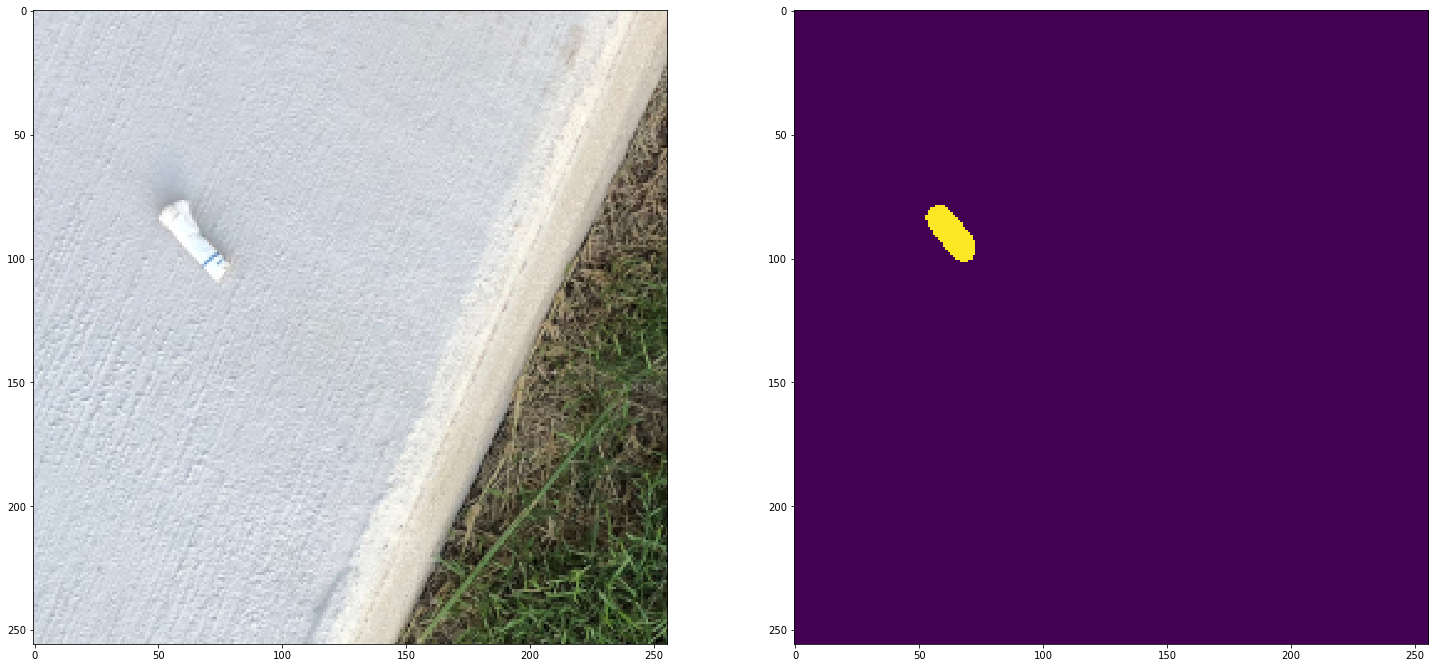

In [198]:
ind_id=3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(new_test[ind_id])
axes[1].imshow(answer_test[ind_id, ..., 0] > 0.2)

In [171]:
A=[]